# 0.0 Imports

## 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import re

from IPython.core.display import HTML

from sklearn.cluster import KMeans
from sklearn import metrics as m
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling import ProfileReport

from umap import UMAP

from boruta import BorutaPy
from heatmap import heatmap, corrplot


## 0.2 Helper Functions



In [2]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    #matplotlib notebook
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

## 0.3 Data Loading



In [3]:
df0 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')
# source https://www.kaggle.com/vik2012kvs/high-value-customers-identification
# other https://github.com/provezano/UK-High-Value-Customers-Identification/tree/main/data

## 0.4 Columns Description



### Attribute Description
- InvoiceNo Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode Product (item) code
- Description Product (item) name
- Quantity The quantities of each product (item) per transaction
- InvoiceDate The day when each transaction was generated
- UnitPrice Unit price (Product price per unit)
- CustomerID Customer number (Unique ID assigned to each customer)
- Country Country name (The name of the country where each customer resides)

## 0.5 Solution Method

### IOT Input Output Visualizing

The aim is to build a data solution similar to this [draft](https://docs.google.com/spreadsheets/d/1zmBQAxvlx-nWgziQZmoL7lx-F1maMAMp5qlVD2c6AyA/edit?usp=sharing)

Situation: The organization will roll out a fidelity program (Insiders Program) to these customers. Customers should be segmented in a way that it is possible to find the most valuable customers. 

Inputs:
- Data from customer transactions (11-2016 ~ 12-2017)

Outputs:
 - Which customers are eligible to participate in the Insiders program?
 - How many customers will be part of the group?
 - What are the main characteristics of these customers?
 - What percentage of revenue contribution comes from Insiders?
 - What is the revenue expectation of this group for the coming months?
 - What are the conditions for a person to be eligible for Insiders?
 - What are the conditions for a person to be removed from Insiders?
 - Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
 - What actions can the marketing team take to increase revenue?

### Tasks:
- Which customers are eligible to participate in the Insiders program?
    - High Value
    - High Average Transaction Value
    - High Frequency (customer is frequently buying)
    - Low Recency (customer has bough recently)
    - High LTV
    - High Basket Size

- How many customers will be part of the group?
- What are the main characteristics of these customers?
- What percentage of revenue contribution comes from Insiders?
- What is the revenue expectation of this group for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
- What actions can the marketing team take to increase revenue?

### Business Understanding and Metrics
- RFM Recency Frequency Monetary Analysis
    - Formula: ((Total distinct customers at end of period) - (Total new distinct customers acquired during period)) / (Total distinct customers at start of period)
- Average Customer Spend = Customers Annual Average Spend Per Purchase * Annual Purchase Frequency
- Average Transaction Value = Annual Revenue/ Invoces Raised


# 1.0 Data Description


In [4]:
df1 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')

## 1.1 Rename Columns

In [5]:
cols_old = df1.columns.tolist()

cols_new = [inflection.underscore(col) for col in cols_old]
cols_new

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country',
 'unnamed: 8']

In [6]:
df1.rename(columns = dict(zip(cols_old, cols_new)), inplace = True )

## 1.2 Data Dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 9


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
unnamed: 8      float64
dtype: object

## 1.4 NA Check

In [9]:
df1.isna().sum()/df1.shape[0]*100

invoice_no        0.000000
stock_code        0.000000
description       0.268311
quantity          0.000000
invoice_date      0.000000
unit_price        0.000000
customer_id      24.926694
country           0.000000
unnamed: 8      100.000000
dtype: float64

In [10]:
df1.drop(columns=['unnamed: 8'], inplace = True)
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.5 NA Fillout

Won't use in this cycle

In [11]:
df1.dropna(subset=['customer_id'], axis = 0, inplace =  True)
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Changing Data Types


In [12]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [14]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y' )

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [16]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
quantity,"-80,995.00","80,995.00","161,990.00",12.06,5.00,248.69,0.18,"94,317.56"
unit_price,0.00,"38,970.00","38,970.00",3.46,1.95,69.32,452.22,"246,924.54"
customer_id,"12,346.00","18,287.00","5,941.00","15,287.69","15,152.00","1,713.60",0.03,-1.18


### Things to check on Variable Filtering

- quantity min and max seems to be outliers (negatives are returns)
- unit price 0 makes no sense (promo? return?)

### 1.7.2 Categorical Attributes

In [17]:
cat_att = df1.select_dtypes(include = 'object')
cat_att.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [18]:
# Select all rows that have non numerical values (\D = digit)
idx = cat_att['invoice_no'].apply( lambda x : bool(re.search( "\D", x ) ) )
print( 'number of occurrences: ', len(cat_att.loc[ idx == True, 'invoice_no' ]))
print( 'number of invoices: ', len(cat_att.loc[ idx == True, 'invoice_no' ].drop_duplicates()))

# bool(re.search( '\D', '123') )

number of occurrences:  8905
number of invoices:  3654


In [19]:
# contains any letter
idx = cat_att['stock_code'].apply( lambda x : bool(re.search( "[a-zA-Z]+", x ) ) )
print( 'number of occurrences: ', len(cat_att.loc[ idx == True, 'stock_code' ]))
print( 'number of invoices: ', len(cat_att.loc[ idx == True, 'stock_code' ].drop_duplicates()))

cat_att.loc[ idx == True ].head()

number of occurrences:  35809
number of invoices:  886


,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
45,536370,POST,POSTAGE,France


# 2.0 Data Filtering

## 2.1 Data Inspection

In [20]:
df2 = df1.copy()

### Invoice Number

In [21]:
# selecting all non digits
df_invoice = df2.loc[ df2['invoice_no'].apply( lambda x: bool(re.search( '\D+', x )) )]
df_invoice.head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


In [22]:
df_invoice['quantity'].max()

# invoices that contain C are probably a chargeback operation
# all quantities are negative

-1

In [23]:
# selecting all non digits
df_invoice = df2.loc[ df2['invoice_no'].apply( lambda x: bool(re.search( '^[\D]+$', x )) )]
df_invoice.head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


### Stock Code

In [24]:
# selecting rows with at least 1 occurrence of non digit
df_stock = df2.loc[df2['stock_code'].apply( lambda x: bool( re.search( '\D+' , x) ) )]
df_stock.head(10)


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
51,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
60,536373,82494L,WOODEN FRAME ANTIQUE WHITE,6,2016-11-29,2.55,17850,United Kingdom
61,536373,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
62,536373,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [25]:
# selecting rows with only non digits
df_stock = df2.loc[df2['stock_code'].apply( lambda x: bool(re.search('^[\D]+$', x)) )]
df_stock.head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2016-11-29,18.95,16274,United Kingdom
4406,536779,BANK CHARGES,Bank Charges,1,2016-11-30,15.00,15823,United Kingdom
5073,536840,POST,POSTAGE,1,2016-11-30,18.00,12738,Germany
5258,536852,POST,POSTAGE,1,2016-12-01,18.00,12686,France
5325,536858,POST,POSTAGE,2,2016-12-01,40.00,13520,Switzerland


In [26]:
# values to remove
drop_stock = df_stock['stock_code'].unique().tolist()

df_stock['stock_code'].value_counts()

POST            1196
M                465
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: stock_code, dtype: int64

###  Quantity

In [27]:
# negative quantities
df2.loc[ df2['quantity'] <0 ].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


In [28]:
df2[df2['invoice_no'] == 'C536391']

# invoice_no is of returns is different than that of purchases

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom


In [29]:
df2[df2['customer_id'] == 17548].sort_values('stock_code')

# some returns appear to not have been bought outside the period the dataset was generated.
# It could either be a item purchased before min date, or an error

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
177227,C552049,22079,RIBBON REEL HEARTS DESIGN,-10,2017-05-04,1.65,17548,United Kingdom
165027,550755,22079,RIBBON REEL HEARTS DESIGN,10,2017-04-18,1.65,17548,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2017-04-18,1.65,17548,United Kingdom
177226,C552049,22081,RIBBON REEL FLORA + FAUNA,-10,2017-05-04,1.65,17548,United Kingdom
177225,C552049,22082,RIBBON REEL STRIPES DESIGN,-10,2017-05-04,1.65,17548,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2017-04-18,1.65,17548,United Kingdom


In [30]:
df2.sort_values( 'quantity' ).head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.03,15838,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2017-04-16,2.10,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2017-04-16,1.85,15749,United Kingdom
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2017-04-16,2.55,15749,United Kingdom
224419,C556522,22920,HERB MARKER BASIL,-1515,2017-06-11,0.55,16938,United Kingdom
187609,C552995,M,Manual,-1350,2017-05-10,0.16,18133,United Kingdom
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2017-04-16,2.55,15749,United Kingdom
390548,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,2017-10-09,1.06,16029,United Kingdom


In [31]:
df2[df2.customer_id == 15749].sort_values('stock_code', ascending = True)

# it appears this customer indeed bought and returned these products

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2017-01-09,2.10,15749,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2017-04-16,2.10,15749,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2017-04-16,2.10,15749,United Kingdom
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2017-01-09,1.85,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2017-04-16,1.85,15749,United Kingdom
160545,550461,21175,GIN + TONIC DIET METAL SIGN,2000,2017-04-16,1.69,15749,United Kingdom
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2017-01-09,2.55,15749,United Kingdom
160543,550461,47556B,TEA TIME TEA TOWELS,1300,2017-04-16,2.10,15749,United Kingdom
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2017-04-16,2.55,15749,United Kingdom
52772,540818,48185,DOORMAT FAIRY CAKE,670,2017-01-09,6.75,15749,United Kingdom


### Description

In [32]:
df2.sort_values('quantity', ascending = False).head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,16446,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.04,12346,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2017-11-23,0.00,13256,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2017-10-25,0.21,12901,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2017-05-25,0.72,13135,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2017-02-20,0.82,18087,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2017-07-17,0.06,14609,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2017-04-16,2.10,15749,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2017-01-09,2.10,15749,United Kingdom
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2017-10-31,0.32,16308,United Kingdom


In [33]:
df2['description'].nunique()

# nothing obvious to do with this feature in this cycle

3896

### Unit Price

In [34]:
df2.loc[df2['unit_price'] == 0]

# I don't know why some prices are zero. For now, I'll remove theese

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2016-12-03,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2016-12-14,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2016-12-19,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2017-01-04,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2017-01-04,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2017-01-11,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2017-02-08,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2017-03-21,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2017-03-28,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2017-04-02,0.0,14410,United Kingdom


In [35]:
# checking some customers
df2.loc[(df2.customer_id == 12444) & (df2.stock_code == '23407')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
393051,570793,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2017-10-10,9.95,12444,Norway
480629,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2017-11-16,9.95,12444,Norway
480649,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2017-11-16,0.00,12444,Norway


In [36]:
df2.loc[(df2['unit_price'] < 0.1) & (df2['unit_price'] != 0) ].sort_values('unit_price').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,13952,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,15618,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,13405,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,16198,United Kingdom
108088,C545478,D,Discount,-720,2017-03-01,0.010,16422,United Kingdom


In [37]:
df2.sort_values( 'unit_price', ascending = False).head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
222681,C556445,M,Manual,-1,2017-06-08,38970.00,15098,United Kingdom
173382,551697,POST,POSTAGE,1,2017-05-01,8142.75,16029,United Kingdom
173277,C551685,POST,POSTAGE,-1,2017-05-01,8142.75,16029,United Kingdom
173391,C551699,M,Manual,-1,2017-05-01,6930.00,16029,United Kingdom
268027,C560372,M,Manual,-1,2017-07-16,4287.63,17448,United Kingdom


### Country

In [38]:
#df2['country'].value_counts(normalize = True)
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [39]:
#countries to drop
drop_country = ['Unspecified', 'European Community']

## 2.2 Data Filtering

In [40]:
# dropping stock code
df2 = df2.loc[~ df2['stock_code'].isin(drop_stock)]

# dropping countries
df2 = df2.loc[~ df2['country'].isin(drop_country)]

# price == 0

# separating returns from purchases
df_returns = df2.loc[ df2['quantity'] < 0 ]
df_purchases = df2.loc[ df2['quantity'] >= 0 ]

In [41]:
df2.to_csv('../data/interim/df2.csv', index = False)

# 3.0 Feature Engineering

Now lets calculate recency, frequency and monetary using only purchases (not considering returns as a interaction)

In [4]:
# Reading Data
# df3 = df2.copy()

df3 = pd.read_csv('../data/interim/df2.csv')
df3['invoice_date'] = pd.to_datetime( df3['invoice_date'] )

# separating returns from purchases
df_returns = df3.loc[ df3['quantity'] < 0 ]
df_purchases = df3.loc[ df3['quantity'] >= 0 ]

### Recency

In [46]:
# days since last purchase (considering first day as day after last invoice)
df_recency = df_purchases[['customer_id', 'invoice_date']].copy()
df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')

# using final date as max date + 1
df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace = True)


### Average Days Between Purchases

In [47]:
df_dates = df_purchases[['customer_id', 'invoice_date']].copy()

# creates a column with the dates shifted by 1 to calculate difference betwenn last purchase and previous purchase
df_dates = df_dates.drop_duplicates()
df_dates['previous_date'] = df_dates.groupby('customer_id')['invoice_date'].shift()

# extracts days betwenn last purchase and previous purchase for each pair of dates
df_dates['days'] = df_dates.apply(lambda x : (x['invoice_date'] - x['previous_date']).days , axis = 1 )

# calculating average of days between purchases
df_dates = df_dates[['customer_id', 'days']].groupby('customer_id').mean().reset_index().rename(columns = {'days': 'avg_days_bw_purchases'})

df_dates.fillna(value = 0, inplace = True)
# df_dates.head()

### Frequency

In [48]:
# Frequency
# nº of purchases a customer did
df_freq = df_purchases[['invoice_no', 'customer_id']].drop_duplicates('invoice_no').groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_purchases'} ) #'invoice_date',  #['num_of_purchases']

# difference between firts and last transaction
# if nº purchases made = 1: date range =  today - first purchase date
# else last purchase - first purchase
func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days

# aggregating things
df_date_range = df_purchases[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})

df_freq = df_freq.merge(df_date_range, on = 'customer_id', how = 'left')
df_freq['frequency'] = df_freq['num_purchases']/df_freq['date_range']

# df_freq.head()

### Revenue

In [89]:
# revenue
# copying from original dataset so that revenue represents net earnings (purchases - returns)
df_revenue = df3[['unit_price','quantity','customer_id']].copy()
df_revenue['quantity'] = df_revenue['quantity'].astype(float)
df_revenue['customer_spend'] = df_revenue['unit_price']*df_revenue['quantity']

# calculating revenue
df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').sum().reset_index().rename(columns = {'customer_spend' : 'revenue'})

# defining number of purchases
df_revenue = df_revenue.merge( df_freq[['customer_id', 'num_purchases']], on = 'customer_id', how = 'left' )

# calculating avg ticket
df_revenue['avg_ticket'] = df_revenue['revenue']/df_revenue['num_purchases']
df_revenue.drop('num_purchases', axis = 1, inplace = True)

# # deleting rows that we have data about return and not about purchase (purchase outside time frame of dataset)
df_revenue = df_revenue[ df_revenue['revenue'] > 0.1 ].copy()
# df_revenue.head()

### Basket Size

In [82]:
# selecting cols
df_basket = df3[['customer_id', 'invoice_no', 'quantity']].copy()

# counting items per invoice
df_basket = df_basket.groupby(['customer_id', 'invoice_no']).sum().reset_index()

# calculating mean of items per invoice
df_basket = df_basket.groupby(['customer_id']).mean().reset_index()

# renaming
df_basket = df_basket.rename( columns = {'quantity' : 'avg_basket_size'})

# df_basket.head()

### Average Unique Products Purchased Quantity

In [83]:
# selecting cols
df_unique = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# counting number of different products per invoice
df_unique = df_unique.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# calculating mean of items per invoice
df_unique = df_unique.groupby(['customer_id']).mean().reset_index()

# # renaming
df_unique = df_unique.rename( columns = {'stock_code' : 'avg_unique_prods'})

# df_unique.head()

In [29]:
# selecting cols
df_unique = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# counting number of different products per invoice
df_unique = df_unique.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# calculating mean of items per invoice
df_unique = df_unique.groupby(['customer_id']).mean().reset_index()

# # renaming
df_unique = df_unique.rename( columns = {'stock_code' : 'avg_unique_prods'})

# df_unique.head(10)
# df_unique[df_unique.customer_id == 12347]['stock_code'].nunique()

In [30]:
# # ATTEMPT THIS LATER IF THERE'S TIME
# ### Avg Amount of New Products Purchased
# df_basket = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# # df_basket = df_basket.groupby(['customer_id', 'invoice_no']).count().reset_index()

# # df_basket = df_basket.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# # 12347
# # df_basket.head(10)
# a = df_basket[df_basket.customer_id.isin([17850,12348]) ] #.stock_code.unique()
# a.invoice_no.unique()

# # a['list'] = a.apply(lambda x: append.(x['stock_code']), axis = 0 )

# # a['list'] = a.groupby('invoice_no')['stock_code'].unique()

# a = df_basket[df_basket.customer_id.isin([17850,12348]) ].copy() #.stock_code.unique()

# # a.groupby('invoice_no')['stock_code'].unique()

# # g = a.groupby( 'customer_id')['invoice_no', 'stock_code'].apply(lambda x: list(np.unique(x)))
# g = a.groupby( ['customer_id', 'invoice_no'])[ 'stock_code'].apply(lambda x: list(np.unique(x)))
# g = pd.DataFrame(g).reset_index()
# # g = g.reset_index()
# g.head()

# df_basket.head()
# df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
#                                                                             .agg( n_purchase=( 'invoice_no', 'nunique'),
#                                                                                    n_products=( 'stock_code', 'nunique' ) )
#                                                                             .reset_index() )
# df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
# df_aux.head()                                                                            

### Returns

In [84]:
# creating returns variables

df_returns = df_returns[['quantity', 'invoice_date', 'unit_price', 'customer_id', 'invoice_no']]

df_returns['customer_spend'] = df_returns['unit_price']*df_returns['quantity']

# sum and mean of revenue
df_returns_metrics = df_returns[['customer_id', 'customer_spend', 'quantity']].groupby('customer_id').agg( 
    returns_revenue = ('customer_spend', 'sum'),
    avg_return_revenue = ('customer_spend', 'mean'),
    num_returns = ('customer_spend', 'count'),
    qty_returned = ('quantity', 'sum')  )

df_returns_metrics = pd.DataFrame( df_returns_metrics.to_records() )

# df_returns_metrics.head()

In [95]:
# merging every feature together

df_processed = df_purchases[['customer_id', 'country']].drop_duplicates('customer_id')
df_processed = pd.merge( df_processed, df_recency, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_dates, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_freq, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_revenue, on = 'customer_id', how = 'inner' )
df_processed = pd.merge( df_processed, df_basket, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_unique, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_returns_metrics, on = 'customer_id', how = 'left' )


# filling na as 0 for customers that never returned an item
df_processed.fillna(value = 0, inplace = True)

df_processed.head()

,customer_id,country,recency,avg_days_bw_purchases,num_purchases,date_range,frequency,revenue,avg_ticket,avg_basket_size,avg_unique_prods,returns_revenue,avg_return_revenue,num_returns,qty_returned
0,17850,United Kingdom,373,1.000000,34,1,34.000000,5288.63,155.547941,48.371429,8.735294,-102.58,-6.838667,15.0,-40.0
1,13047,United Kingdom,57,52.833333,9,317,0.028391,3089.10,343.233333,84.687500,19.000000,-143.49,-6.238696,23.0,-35.0
2,12583,France,3,26.500000,15,371,0.040431,6629.34,441.956000,292.823529,15.466667,-76.04,-25.346667,3.0,-50.0
3,13748,United Kingdom,96,92.666667,5,278,0.017986,948.25,189.650000,87.800000,5.600000,0.00,0.000000,0.0,0.0
4,15100,United Kingdom,334,20.000000,3,40,0.075000,635.10,211.700000,9.666667,1.000000,-240.90,-80.300000,3.0,-22.0


In [96]:
df_processed.to_csv('../data/interim/df3_interim.csv', index = False)

# 4.0 Exploratory Data Analysis

In [23]:
df5.customer_id.nunique()

4314

In [3]:
df4 = pd.read_csv('../data/interim/df3_interim.csv')

## 4.1 Univariate Analysis

In [79]:
profile = ProfileReport(df4)
profile.to_file(output_file= '../reports/features_report.html' ) 

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


### 4.1.1 Revenue

In [101]:
df4.sort_values('revenue', ascending = False).head(10)

,customer_id,country,recency,avg_days_bw_purchases,num_purchases,date_range,frequency,revenue,avg_ticket,avg_basket_size,avg_unique_prods,returns_revenue,avg_return_revenue,num_returns,qty_returned
844,14646,Netherlands,2,8.022727,73,353,0.206799,278778.02,3818.876986,2663.945946,28.273973,-360.00,-180.000000,2.0,-288.0
419,18102,United Kingdom,1,14.680000,60,367,0.163488,259657.30,4327.621667,1068.733333,7.183333,0.00,0.000000,0.0,0.0
372,17450,United Kingdom,9,13.807692,46,359,0.128134,189735.53,4124.685435,1409.000000,7.304348,-4815.26,-1605.086667,3.0,-952.0
65,14911,EIRE,2,2.861538,199,372,0.534946,133007.13,668.377538,317.617284,28.492462,-7443.59,-33.379327,223.0,-3332.0
912,12415,Australia,25,22.357143,20,313,0.063898,123638.18,6181.909000,3218.416667,35.750000,-926.35,-15.186066,61.0,-427.0
199,14156,EIRE,10,8.619048,55,362,0.151934,114505.32,2081.914909,877.323077,25.327273,-2874.31,-151.279474,19.0,-859.0
15,17511,United Kingdom,3,13.740741,31,371,0.083558,88138.20,2843.167742,1400.311111,31.064516,-2924.18,-26.343964,111.0,-1535.0
800,16684,United Kingdom,5,23.600000,28,354,0.079096,65920.12,2354.290000,1646.366667,9.892857,-733.44,-244.480000,3.0,-864.0
35,13694,United Kingdom,4,10.882353,50,370,0.135135,62924.10,1258.482000,1084.350877,11.360000,-2115.52,-151.108571,14.0,-1504.0
8,15311,United Kingdom,1,4.191011,91,373,0.243968,59419.34,652.959780,319.661017,25.901099,-1348.56,-12.040714,112.0,-474.0


In [6]:
# taking a look at the customers that bought more items and it seems like normal behaviour
df3[df3['customer_id'] == 14646]
df3[df3['customer_id'] == 18102]
df3[df3['customer_id'] == 17450]

len(df3.loc[ (df3['customer_id'] == 17450) & (df3['quantity'] < 0) ] )

3

In [4]:
### Returns

df4.sort_values(['returns_revenue'], ascending = True).head()

# This is propably an anomaly, error, or some data purposely inserted for unknown reasons
# df3[df3.customer_id == 16446]
# df3[df3.customer_id == 12346]

# These customers indeed appear to have returned high quantities
# df3[df3.customer_id == 15749]
# df3[df3.customer_id == 16029]
# df3[df3.customer_id == 12931]

# droping weird behaviour
cust_drop = [16446, 12346]
df4 = df4[ ~ df4['customer_id'].isin(cust_drop)].copy()

### 4.1.2 Basket Size

In [8]:
df4.sort_values('avg_basket_size', ascending=False).head()

,customer_id,country,recency,avg_days_bw_purchases,num_purchases,date_range,frequency,revenue,avg_ticket,avg_basket_size,avg_unique_prods,returns_revenue,avg_return_revenue,num_returns,qty_returned
3393,18251,United Kingdom,88,0.000000,1,88,0.011364,4314.72,4314.720,7824.000000,16.00,0.00,0.000000,0.0,0.0
2685,13135,United Kingdom,197,0.000000,1,197,0.005076,3096.00,3096.000,4300.000000,1.00,0.00,0.000000,0.0,0.0
171,16754,United Kingdom,373,0.000000,1,373,0.002681,2002.40,2002.400,4280.000000,2.00,0.00,0.000000,0.0,0.0
912,12415,Australia,25,22.357143,20,313,0.063898,123638.18,6181.909,3218.416667,35.75,-926.35,-15.186066,61.0,-427.0
3230,12688,Israel,114,0.000000,1,114,0.008772,4873.81,4873.810,3028.000000,171.00,0.00,0.000000,0.0,0.0


In [9]:
df4.sort_values('avg_basket_size', ascending=True).head()

,customer_id,country,recency,avg_days_bw_purchases,num_purchases,date_range,frequency,revenue,avg_ticket,avg_basket_size,avg_unique_prods,returns_revenue,avg_return_revenue,num_returns,qty_returned
2720,17900,United Kingdom,191,0.0,2,191,0.010471,15.00,7.50,0.25,3.0,-97.2,-19.44,5.0,-72.0
2158,17956,United Kingdom,250,0.0,1,250,0.004000,12.75,12.75,1.00,1.0,0.0,0.00,0.0,0.0
1867,13452,United Kingdom,260,11.0,2,11,0.181818,590.00,295.00,1.00,1.0,0.0,0.00,0.0,0.0
3662,16454,United Kingdom,65,0.0,1,65,0.015385,5.90,5.90,2.00,1.0,0.0,0.00,0.0,0.0
2845,16257,United Kingdom,177,0.0,1,177,0.005650,46.95,46.95,2.00,2.0,0.0,0.00,0.0,0.0


## 4.2 Bivariate Analysis

In [111]:
df_bi = df4.select_dtypes(include=['int', 'float'])

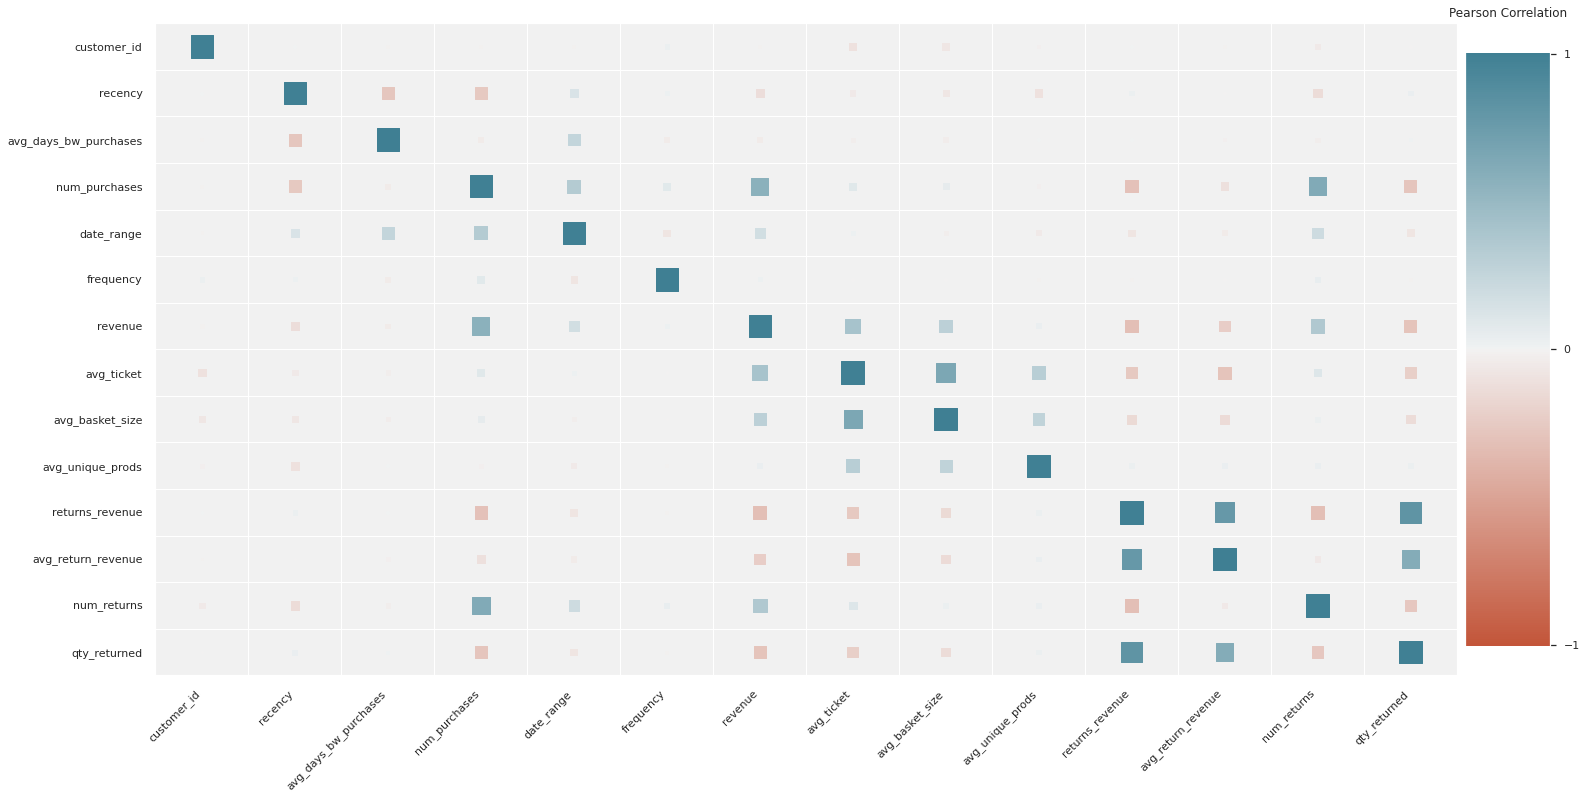

In [16]:
corrplot( df4.corr('pearson') )
plt.title('Pearson Correlation');

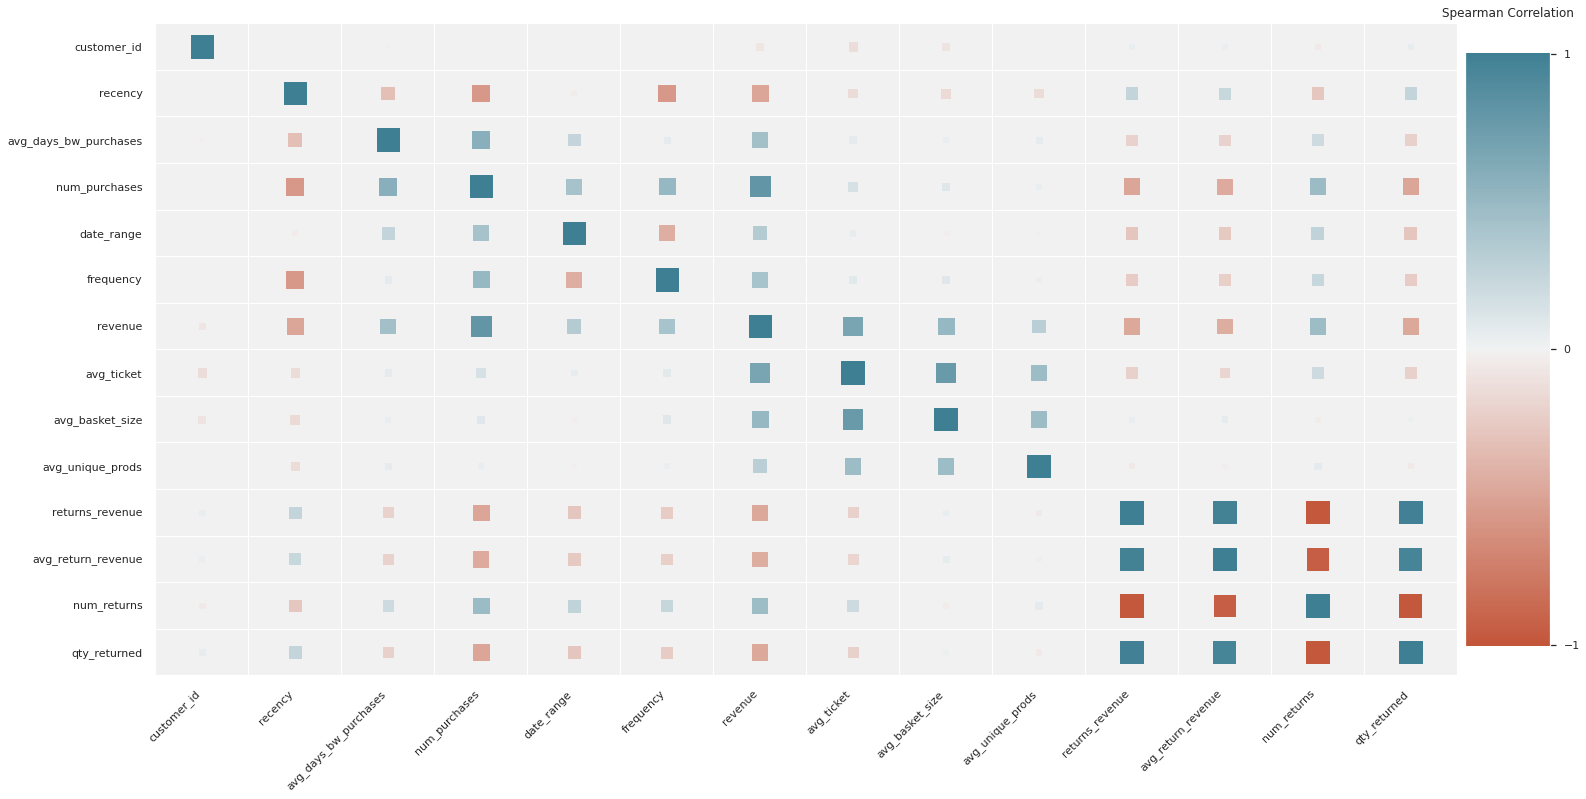

In [15]:
corrplot( df4.corr('spearman') )
plt.title('Spearman Correlation');

## 4.3. Feature Selection using Boruta

In [5]:
rf = RandomForestRegressor(n_jobs = -1, random_state = 42, max_depth = 8)

X = df4.drop(['revenue', 'country'], axis = 1).copy()
X = np.array(X)
y = df4[['revenue']]
y = np.array(y).ravel()

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	6
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	5
Iteration:

BorutaPy(estimator=RandomForestRegressor(max_depth=8, n_estimators=46,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F0995524140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F0995524140, verbose=2)

In [6]:
cols = df4.drop(['revenue', 'country'], axis = 1).columns.tolist()

sup = feat_selector.support_
cols
[cols[i] for i, _ in enumerate(cols) if sup[i]]

['num_purchases',
 'avg_ticket',
 'avg_basket_size',
 'returns_revenue',
 'num_returns']

In [8]:
rank = feat_selector.ranking_
importance = list(zip(rank, cols))
sorted(importance)


[(1, 'avg_basket_size'),
 (1, 'avg_ticket'),
 (1, 'num_purchases'),
 (1, 'num_returns'),
 (1, 'returns_revenue'),
 (2, 'qty_returned'),
 (3, 'avg_days_bw_purchases'),
 (4, 'avg_return_revenue'),
 (5, 'customer_id'),
 (6, 'frequency'),
 (7, 'avg_unique_prods'),
 (8, 'recency'),
 (9, 'date_range')]

I attempted using Boruta to evaluate features predictive power to select features for clustering. However, the algorithm didn't seem to find relevance in possibly important features

In [17]:
df4.to_csv('../data/interim/df4_interim.csv', index = False)

## 4.4 Embedded Space Analysis

### 4.4.1 Preprocessing

In [44]:
# df4.hist();

In [45]:
# selecting numerical cols
numerical_cols = df4.select_dtypes(include = ['int', 'float'] ).columns.tolist()
numerical_cols.remove('customer_id')

# applying min max transform
ct = make_column_transformer( (MinMaxScaler(), numerical_cols) )
df_prep = ct.fit_transform(df4)

### 4.4.2 UMAP Embedding

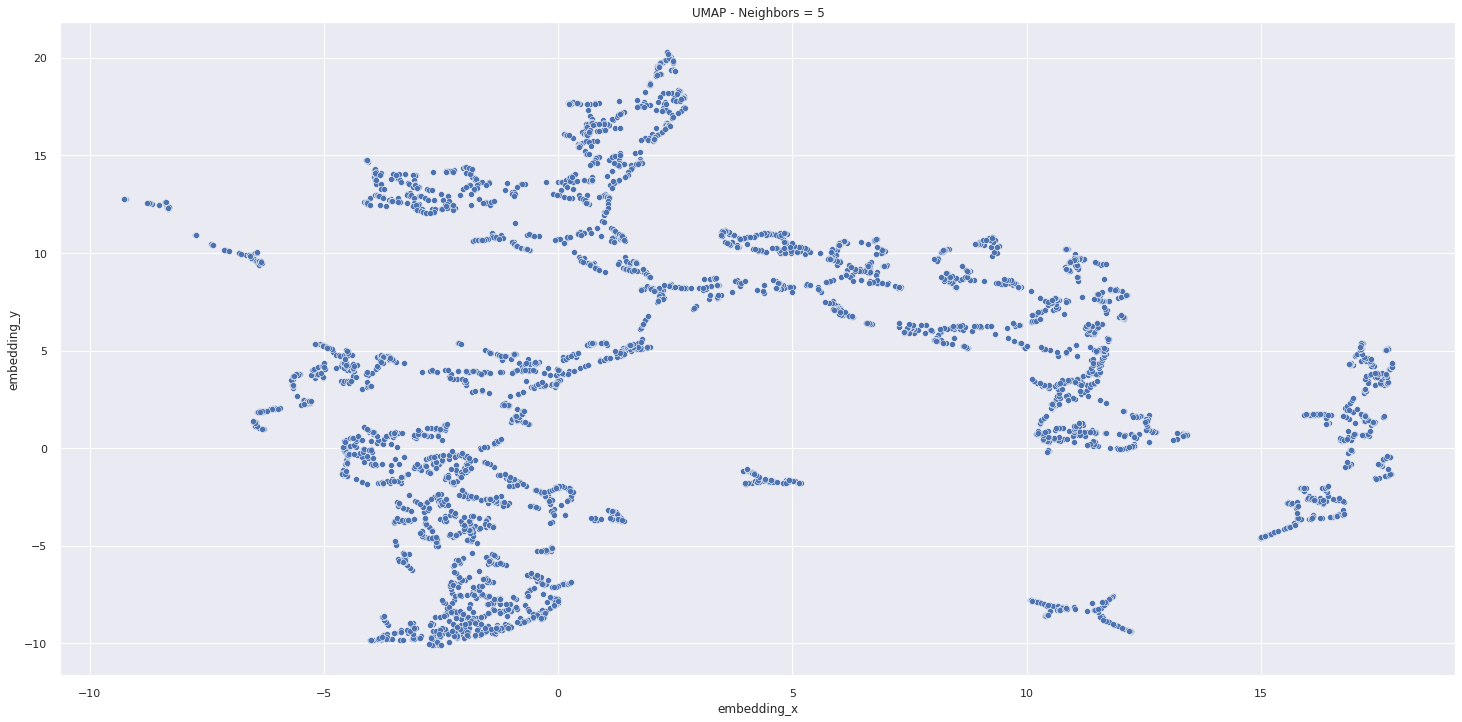

In [49]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 5
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz = df4.copy()
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', palette = 'bright' ); # hue = 'cluster'

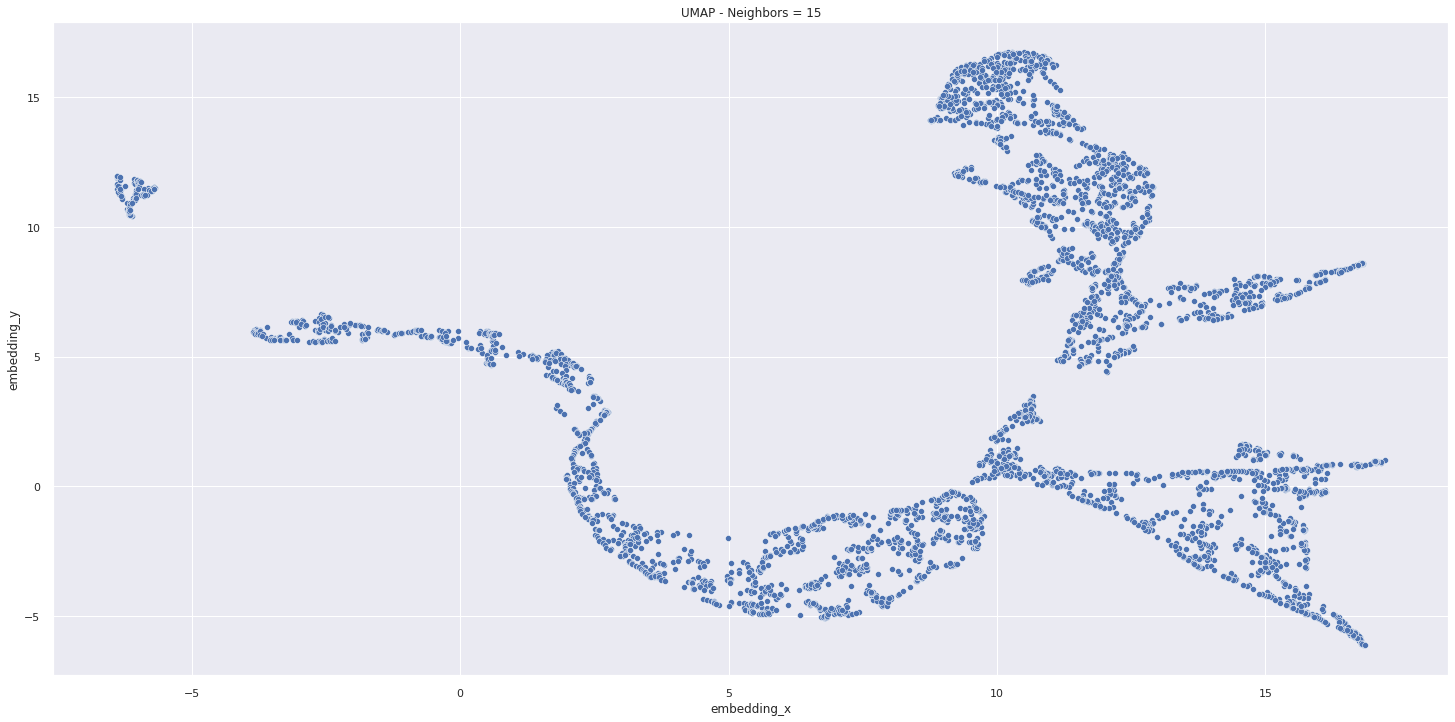

In [50]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 15
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz = df4.copy()
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', palette = 'bright' ); # hue = 'cluster'

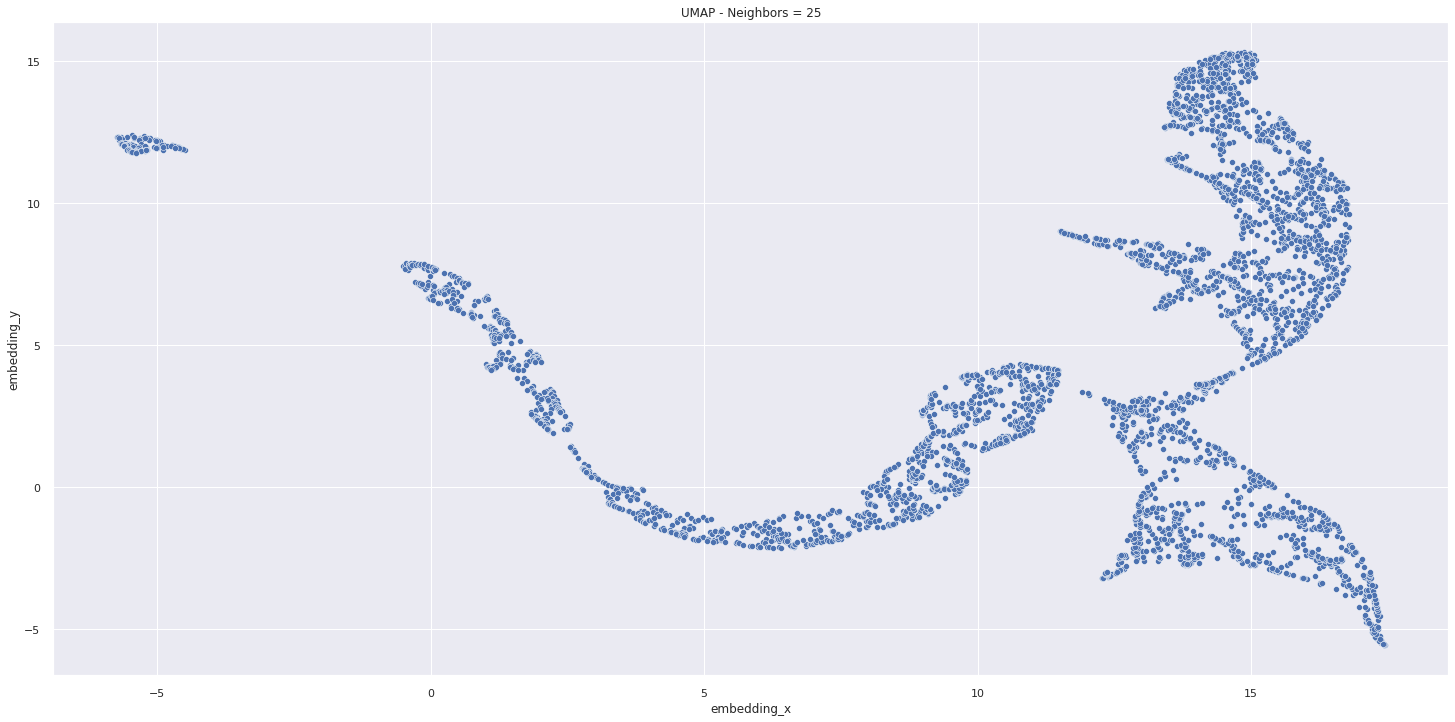

In [51]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 25
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz = df4.copy()
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', palette = 'bright' ); # hue = 'cluster'

These embedded spaces gives us an idea that the data cleaning and feature engineering done in this cycle made data more separable in a higher dimension space.

Proper space studied will be conducted in a next cycle and, possibly we'll clusterize our customers using one embedded space

# 5.0 Data Preparation

## 5.1 Numerical Variables Preparation

In [32]:
df5 = pd.read_csv('../data/interim/df4_interim.csv')

### 5.1.1 Rescaling

In [7]:
# df3.hist();
num_att = df5.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
customer_id,"12,347.00","18,287.00","5,940.00","15,301.83","15,300.50","1,720.16",0.00,-1.20
recency,1.00,374.00,373.00,93.05,51.00,100.17,1.25,0.43
avg_days_bw_purchases,0.00,366.00,366.00,50.57,31.09,65.32,1.99,4.65
num_purchases,1.00,206.00,205.00,4.26,2.00,7.66,11.95,244.12
date_range,1.00,374.00,373.00,187.22,191.00,115.01,0.01,-1.33
frequency,0.00,34.00,34.00,0.05,0.02,0.54,58.77,"3,681.78"
revenue,3.75,"278,778.02","278,774.27","1,922.49",655.34,"8,326.44",21.49,594.95
avg_ticket,3.75,"13,206.50","13,202.75",371.22,283.27,465.09,10.65,202.58
avg_basket_size,0.25,"7,824.00","7,823.75",200.17,140.00,269.91,10.01,193.40
avg_unique_prods,1.00,297.88,296.88,21.65,17.00,19.44,3.30,23.97


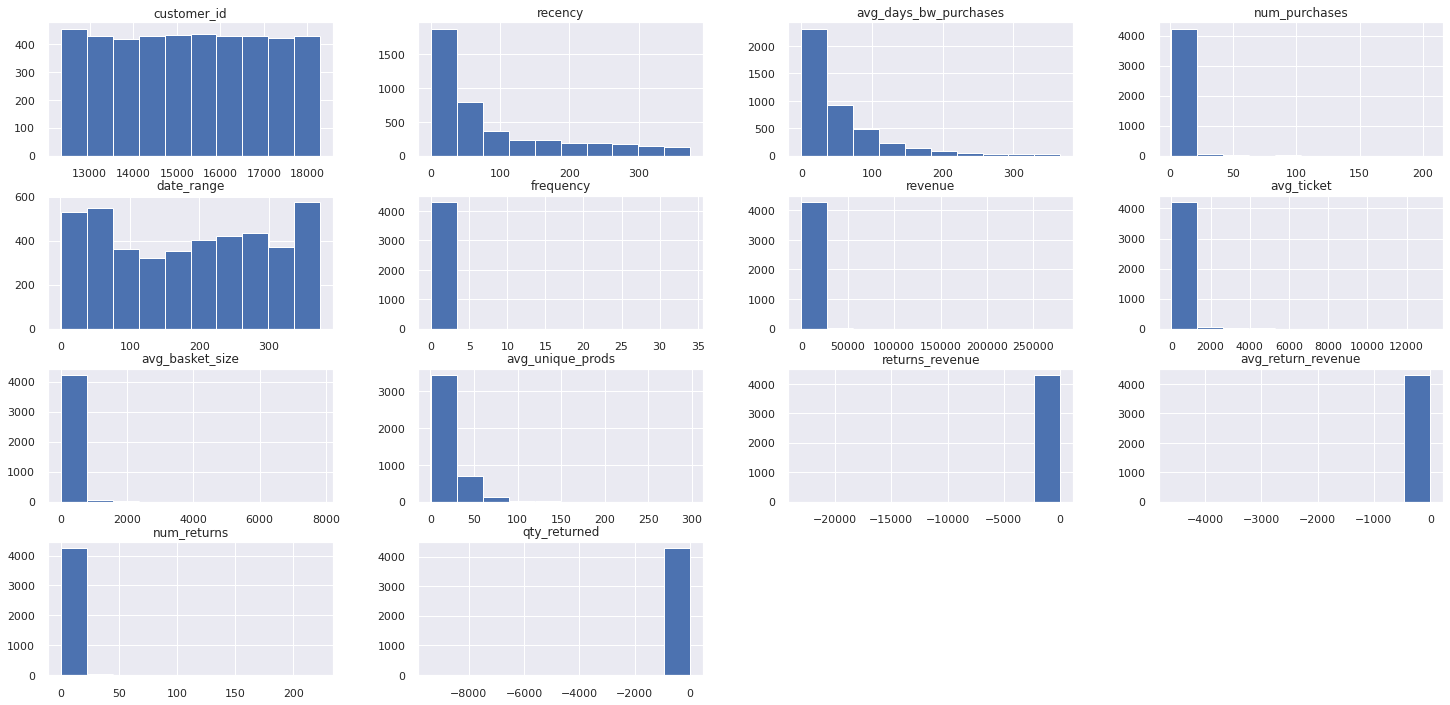

In [8]:
df5.hist();

In [13]:
# df5.columns.tolist()

## 5.2 Preprocessing

In [33]:
# selecting numerical cols, removing customer_id and country
numerical_cols = df5.select_dtypes(include = ['int', 'float'] ).columns.tolist()
numerical_cols.remove('customer_id')

# applying min max transform
ct = make_column_transformer( (MinMaxScaler(), numerical_cols) )
df_minmax = ct.fit_transform(df5)

In [34]:
# defining columns to be transformed
log_cols = ['recency','avg_days_bw_purchases'] 
min_max_cols = ['num_purchases','date_range','frequency','revenue','avg_ticket','avg_basket_size','avg_unique_prods','returns_revenue','avg_return_revenue','num_returns','qty_returned']

log1p = FunctionTransformer(np.log1p)

# applying log and standard scaler to log cols
log_pipe = Pipeline(steps = [ ('log', log1p), ('std', StandardScaler()) ] )
ct_log = ColumnTransformer( transformers = [ ('log', log_pipe, log_cols) ] ) 

# applying min_max scaler to min_max cols
min_max_pipe = make_pipeline( MinMaxScaler() )

# Label Encoding and std_scaler to catgorical columns
label_pipe = make_pipeline( OrdinalEncoder(), MinMaxScaler() )

preprocessor = ColumnTransformer( 
    transformers=[ ('log', log_pipe, log_cols), 
    ('min_max', min_max_pipe, min_max_cols) ] )
df_prep = preprocessor.fit_transform(df5)

df_prep[1]

array([1.56617717e-01, 6.69072435e-01, 3.90243902e-02, 8.47184987e-01,
       7.56452735e-04, 1.10675566e-02, 2.57130775e-02, 1.07924589e-02,
       6.06300773e-02, 9.93760870e-01, 9.98643667e-01, 1.03139013e-01,
       9.96260684e-01])

# 6.0 Feature Selection

# 7.0 Model Testing

## 7.1 KMeans

### 7.1.1 KMeans on Log+ Std and MinMax Preprocessed Data

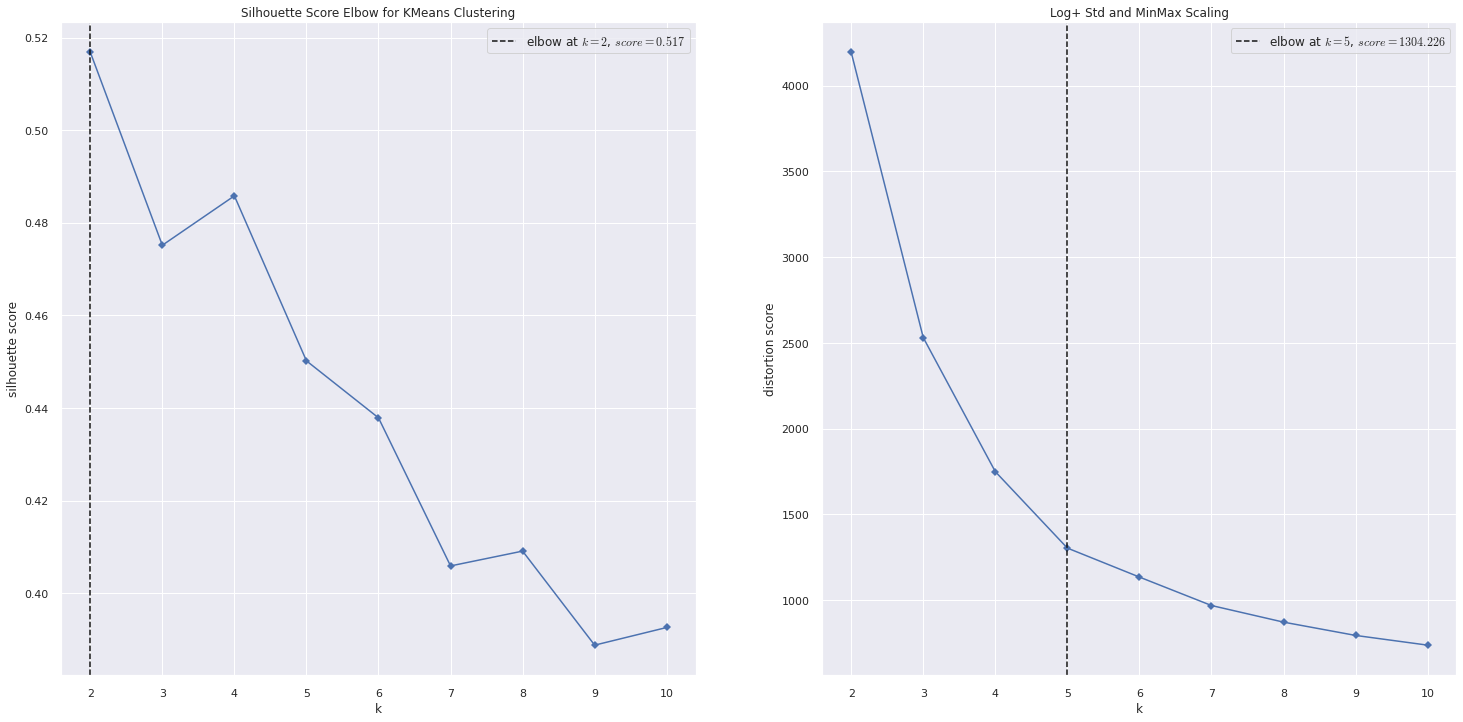

In [15]:
# defining the KMeans algorithm
kmeans = KMeans(random_state = 42)

# ploting 2 different metrics
fig, axes = plt.subplots(1, 2)

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, metric = 'silhouette', ax=axes[0] )
visualizer.fit(df_prep)
visualizer.finalize();

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, ax=axes[1] )
visualizer.fit(df_prep)
visualizer.finalize();
plt.title('Log+ Std and MinMax Scaling')
plt.show();

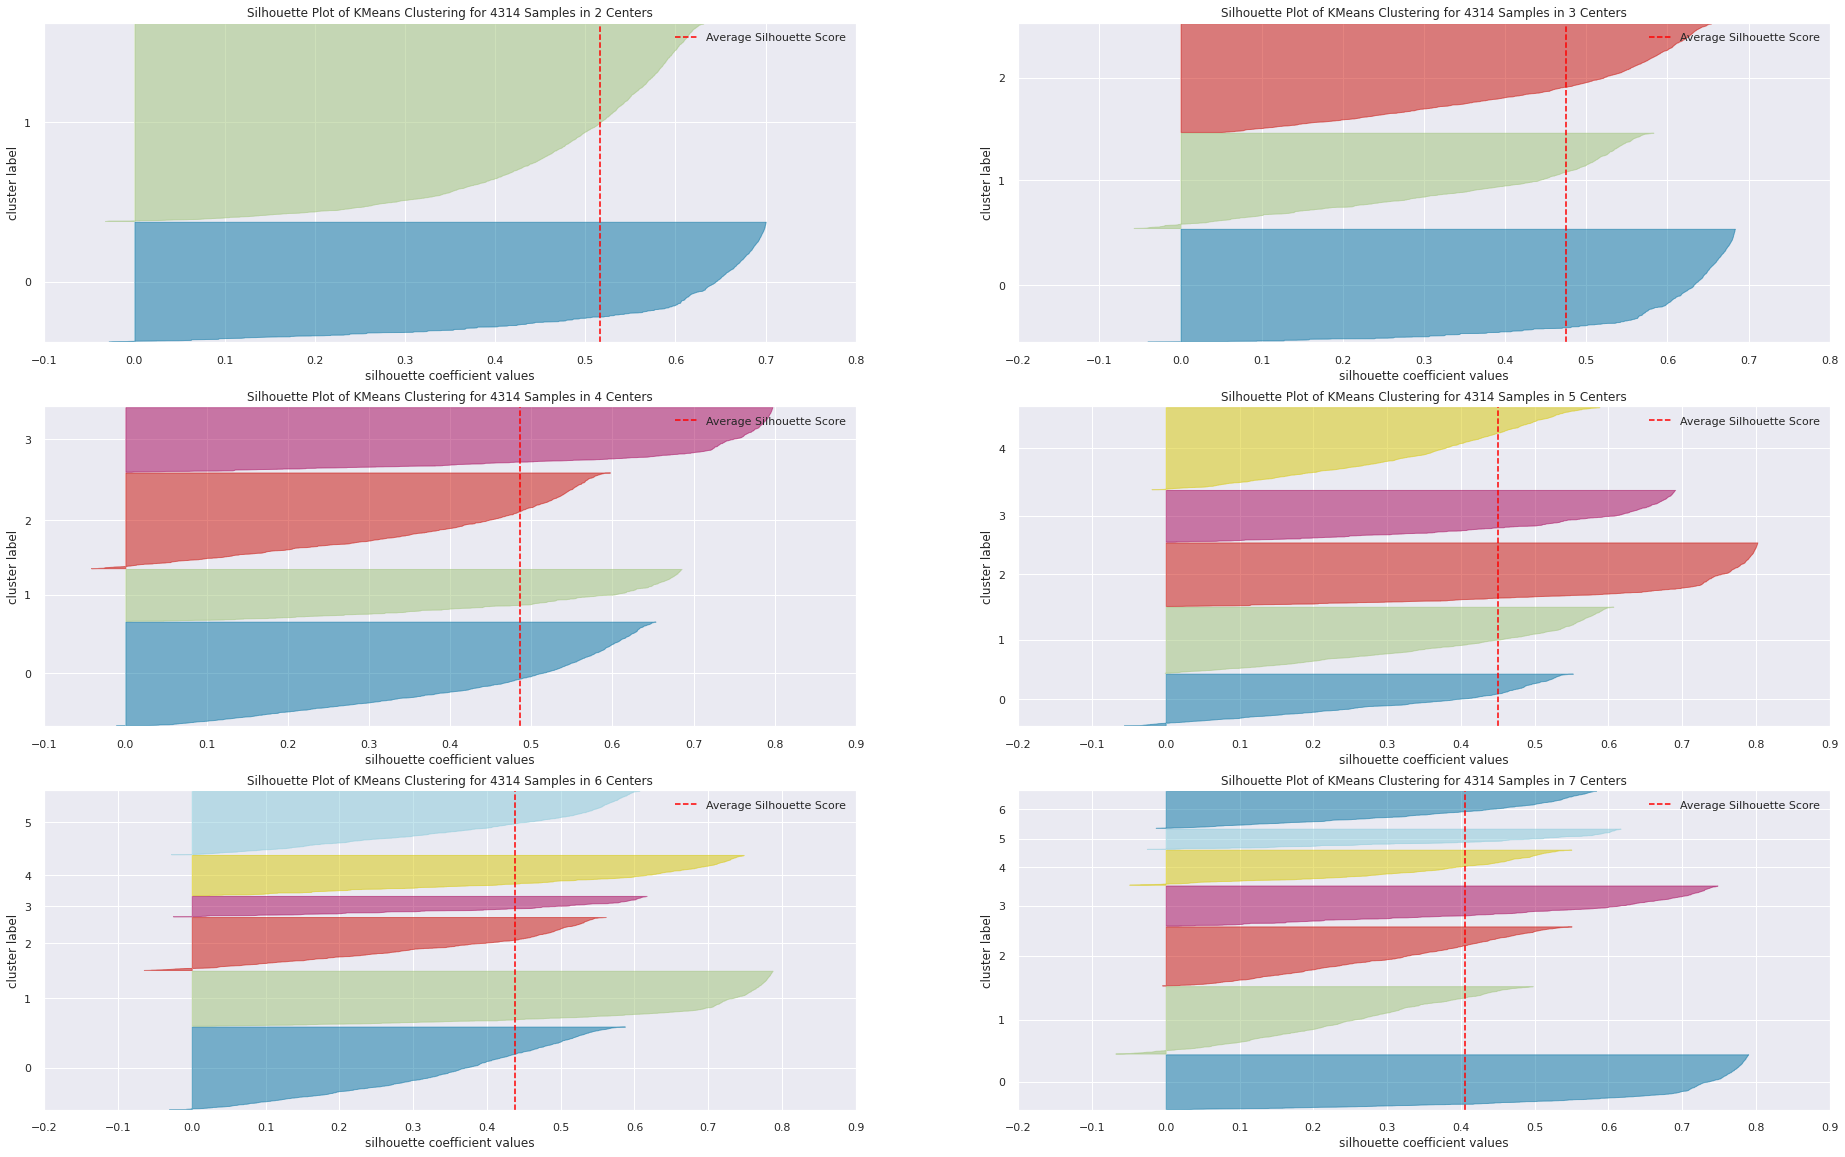

In [16]:
# Testing Clusters Silhouette
fig, axes = plt.subplots(3,2, figsize = (32,20))

# n_clusters from 2 to 7
for n in range(2,8):
    
    kmeans = KMeans(n_clusters = n, random_state = 42)
    # row and column for axes
    row, col = n//2 -1, n%2

    visualizer = SilhouetteVisualizer(kmeans, ax = axes[row][col], colors = 'yellowbrick' )
    visualizer.fit(df_prep)
    visualizer.finalize()

plt.show()

### 7.1.2 KMeans on MinMax Preprocessed Data

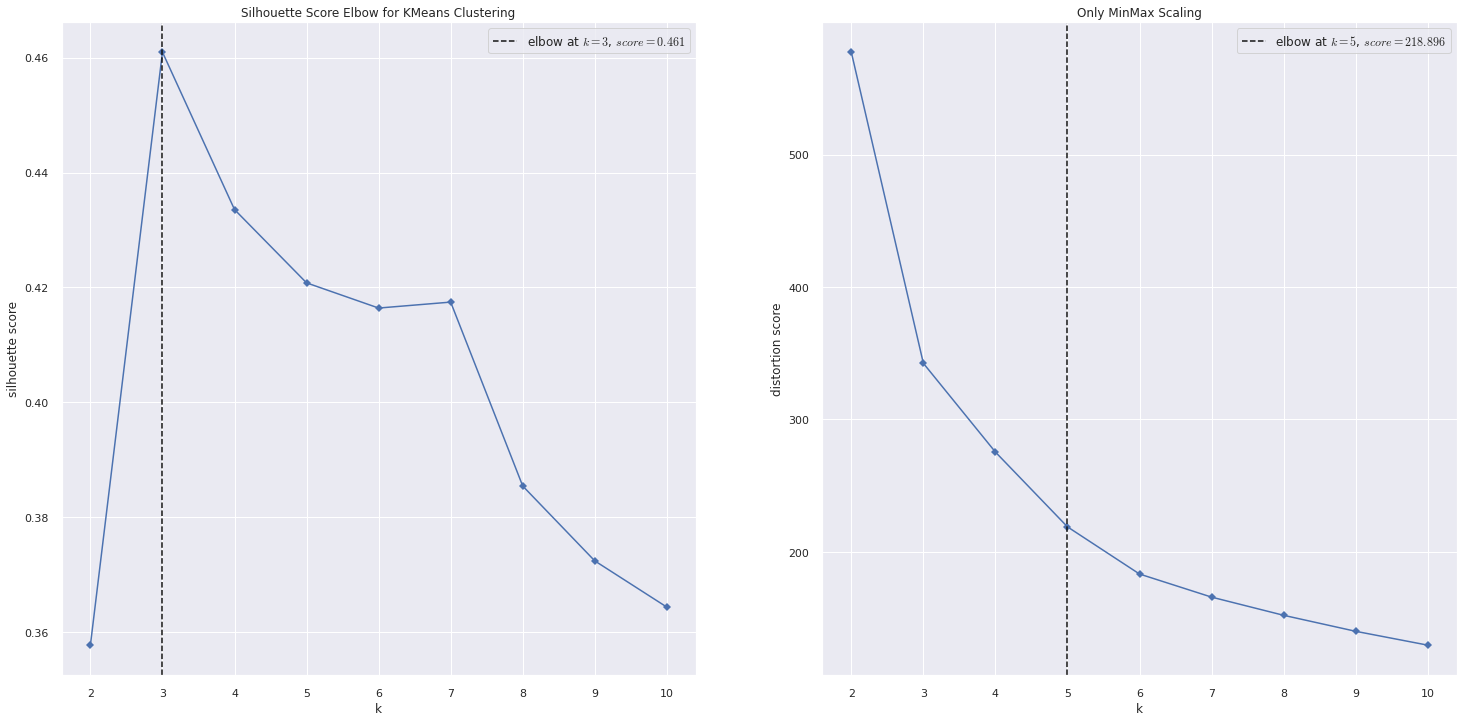

In [17]:
# defining the KMeans algorithm
kmeans = KMeans(random_state = 42)

# ploting 2 different metrics
fig, axes = plt.subplots(1, 2)

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, metric = 'silhouette', ax=axes[0] )
visualizer.fit(df_minmax)
visualizer.finalize();

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, ax=axes[1] )
visualizer.fit(df_minmax)
visualizer.finalize();
plt.title('Only MinMax Scaling')
plt.show();

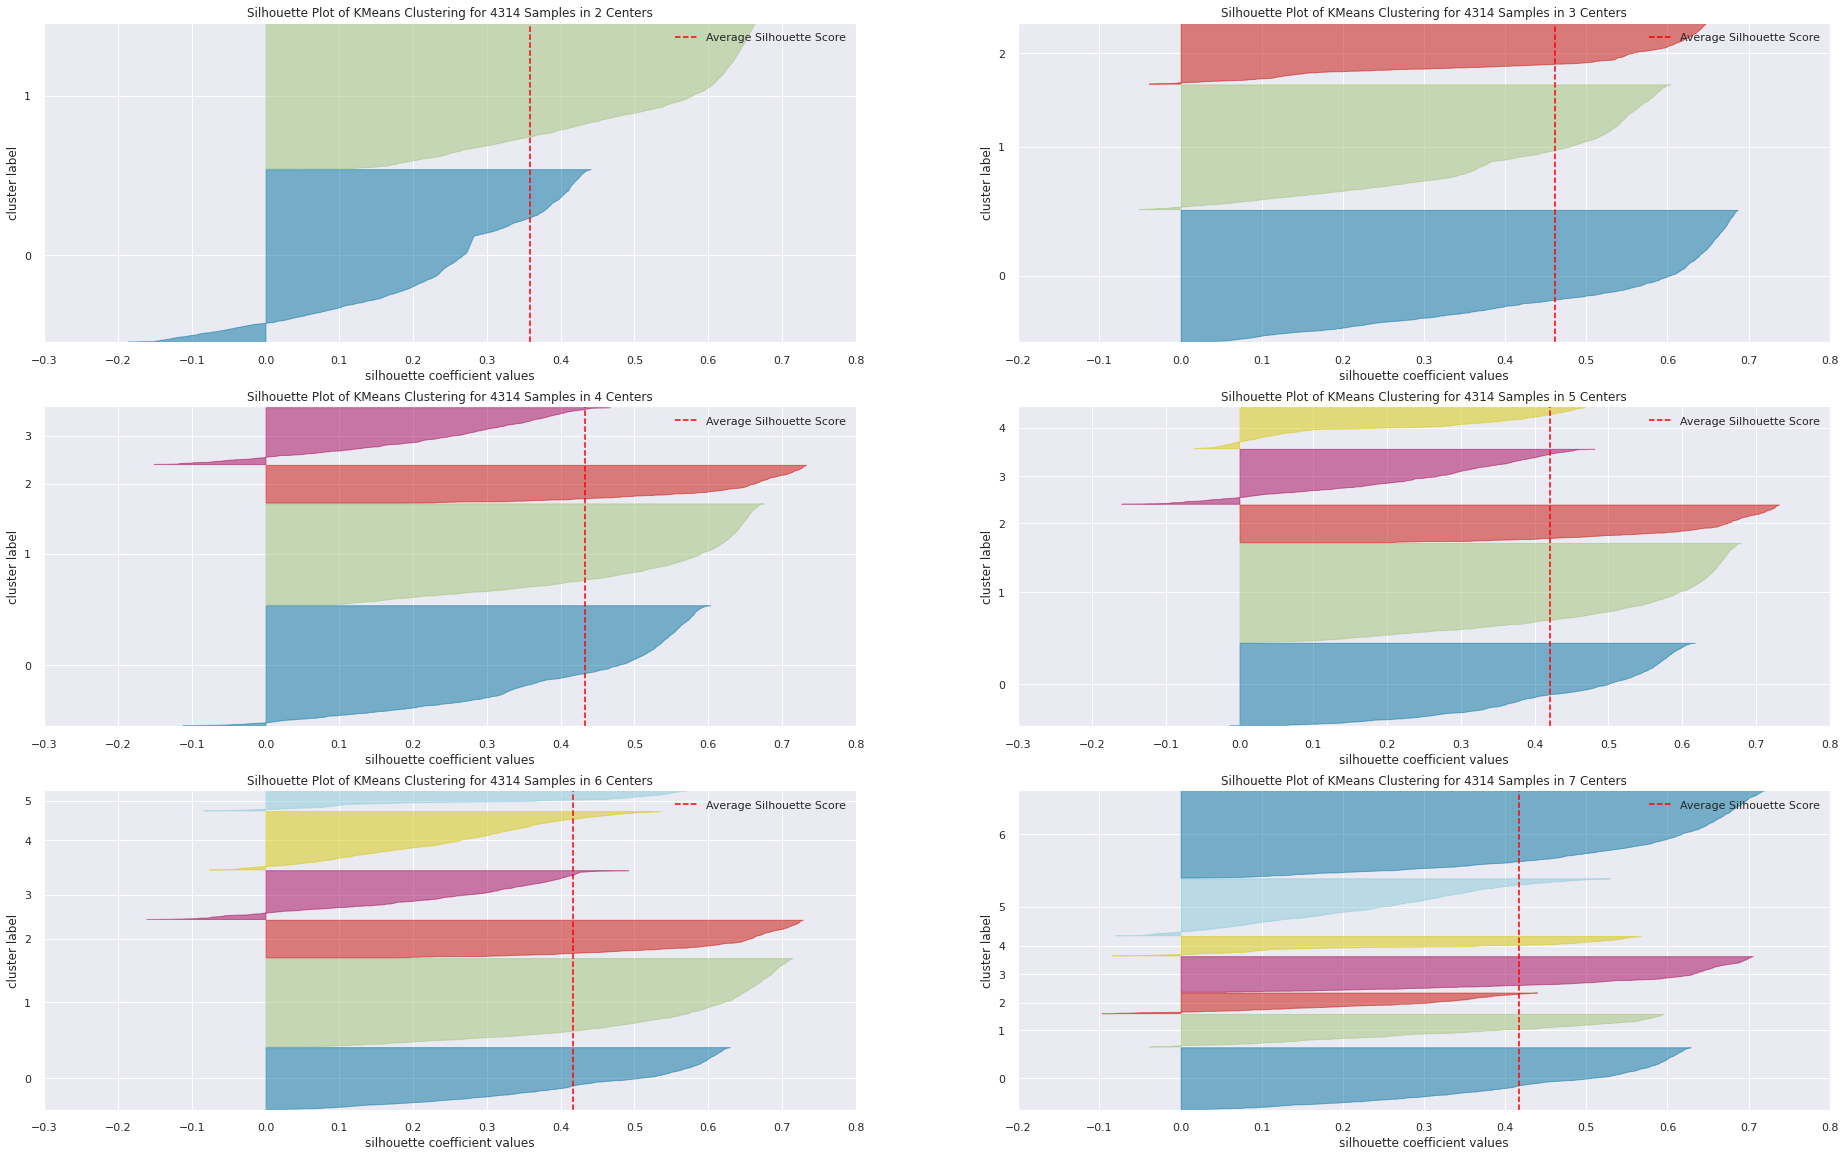

In [18]:
# Testing Clusters Silhouette
fig, axes = plt.subplots(3,2, figsize = (32,20))

# n_clusters from 2 to 7
for n in range(2,8):
    
    kmeans = KMeans(n_clusters = n, random_state = 42)
    # row and column for axes
    row, col = n//2 -1, n%2

    visualizer = SilhouetteVisualizer(kmeans, ax = axes[row][col], colors = 'yellowbrick' )
    visualizer.fit(df_minmax)
    visualizer.finalize()

plt.show()

We see that using log transform and standard scaling revenue and avg_days_bw_purchases increased clustering performance:
 - Higher Silhouette Score
 - Lower Cluster interception (as seen comparing silhouette plots)

Also, cleaning the dataset a little better and engineering new features helped increasing performance in comparison to the last cycle

## 7.2 Comparing Model's Performances

# 8.0 Model Testing

# 9.0 Cluster Analysis

## 9.1 Visual Inspection - Metrics

In [46]:
# aplying a kmeans with n = 5
n_clusters = 10
pipeline = make_pipeline( KMeans(n_clusters = n_clusters, random_state = 42) )
labels = pipeline.fit_predict(df_prep)

# Evaluating Silhouette Score
m.silhouette_score(df_prep, labels)

0.39258450248150906

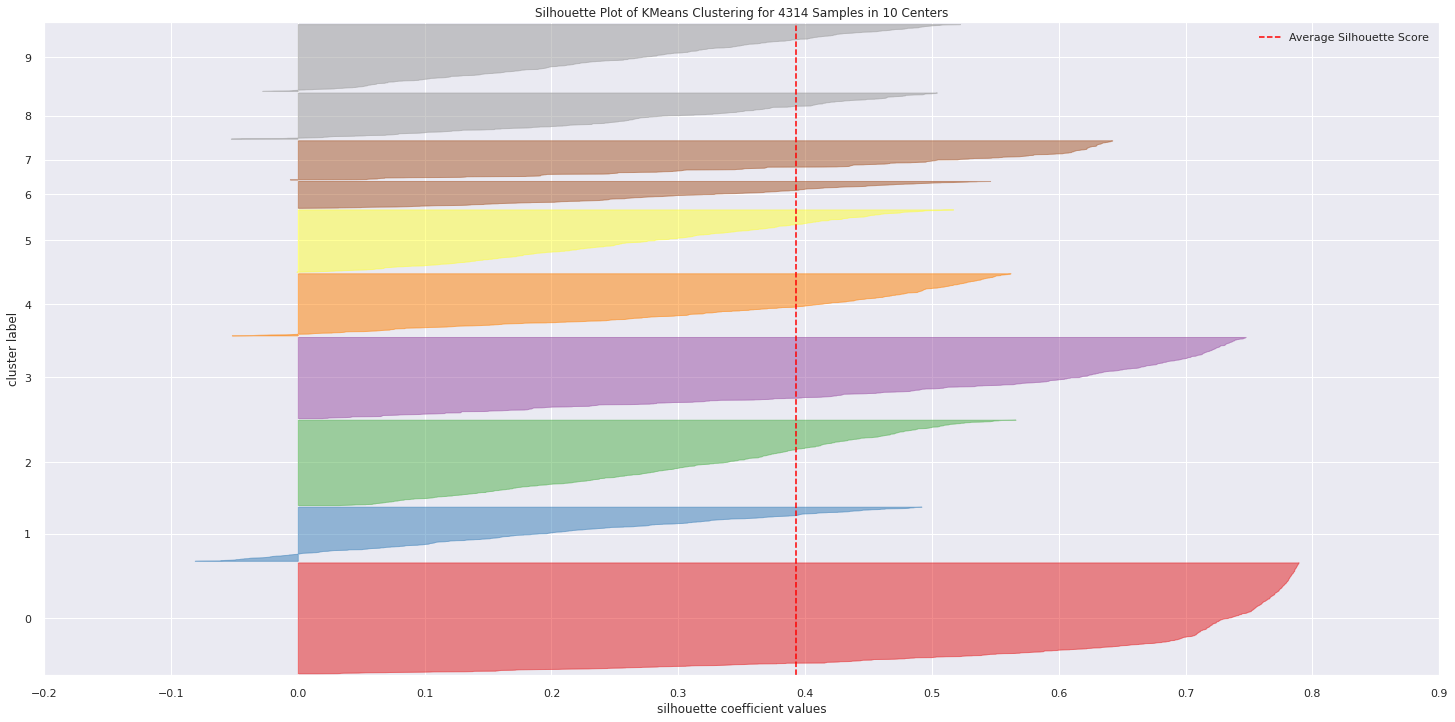

In [47]:
kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
visualizer = SilhouetteVisualizer( kmeans )
visualizer.fit(df_prep)
visualizer.show();

## 9.2 Pairploting Features

In [51]:
# columns from pipeline
# cols = ['recency', 'num_transactions', 'frequency', 'revenue', 'avg_ticket', 'num_returns', 'date_range', 'return_revenue', 'avg_return_revenue', 'country']

# df_viz = pd.DataFrame(df_prep, columns = cols)
df_viz = pd.DataFrame(df_prep)

df_viz['cluster'] = labels
# df_viz.head()

In [38]:
# sns.pairplot(data = df_viz, hue = 'cluster' );

## 9.3 Visual Inspection - UMAP

## 9.4 Business Perspective

In [64]:
# number of customers per cluster
n_cust = df5.copy()
n_cust['cluster'] = labels
n_cust = n_cust.groupby('cluster').count().reset_index().rename(columns = {'customer_id' : 'num_of_customers'})
n_cust['perc_of_customer'] = n_cust['num_of_customers']/n_cust['num_of_customers'].sum()*100
n_cust = n_cust[['cluster', 'num_of_customers', 'perc_of_customer']]

In [70]:
# calculating mean values for each cluster attribute

df_res = df5.copy()
# add cluster to df
df_res =pd.concat( [df_res, pd.DataFrame( { 'cluster' : labels} ) ], axis = 1 )
result = df_res.groupby('cluster').mean().reset_index()

# add nº of customers
result = result.merge( n_cust, on = 'cluster', how = 'inner')
result = result[['cluster', 'num_of_customers', 'perc_of_customer', 'num_purchases', 'date_range', 'frequency', 'recency', 'revenue', 'avg_ticket' ]]
result.sort_values('revenue', ascending = False )

,cluster,num_of_customers,perc_of_customer,num_purchases,date_range,frequency,recency,revenue,avg_ticket
8,8,314,7.278628,15.570064,316.417197,0.046464,3.283439,8412.305032,409.074683
9,9,454,10.523876,8.898678,292.050661,0.029683,13.185022,4429.187599,406.936178
1,1,368,8.530366,5.190217,126.880435,0.061051,33.415761,2257.646304,359.020925
6,6,183,4.242003,4.382514,71.584699,0.079327,6.333333,1743.429836,362.147608
5,5,423,9.805285,3.784870,264.919622,0.014635,27.895981,1471.372813,374.305343
2,2,580,13.444599,3.713793,208.094828,0.018696,75.374138,1384.650517,374.891946
4,4,422,9.782105,3.030806,96.853081,0.047203,189.315166,990.550190,326.833286
3,3,551,12.772369,1.063521,73.526316,0.038838,75.693285,440.585880,417.719551
7,7,266,6.165971,1.116541,19.424812,0.142864,19.808271,429.303271,352.153822
0,0,753,17.454798,1.088977,261.132802,0.057765,263.671979,386.460651,335.103751


In [83]:
# Generating a report of some attributes for each cluster
for i in range( len(np.unique(labels)) ):
    print('Cluster {}'.format(result.loc[i, 'cluster']))
    print(' - Number of customers {} (%{:.2f} of total)'.format(result.iloc[i, 1], result.iloc[i, 2]) )
    print(' - Average nº of transactions: {:.2f} '.format(result.iloc[i, 3]) )
    print(' - Average tenure in days {:.2f} '.format(result.iloc[i, 4]) )
    print(' - Average amount spent in total ${:,.2f} '.format(result.iloc[i, 7]) )
    print(' - Mean values for average ticket ${:,.2f} \n'.format(result.iloc[i, 8]) )

    

Cluster 0
 - Number of customers 753 (%17.45 of total)
 - Average nº of transactions: 1.09 
 - Average tenure in days 261.13 
 - Average amount spent in total $386.46 
 - Mean values for average ticket $335.10 

Cluster 1
 - Number of customers 368 (%8.53 of total)
 - Average nº of transactions: 5.19 
 - Average tenure in days 126.88 
 - Average amount spent in total $2,257.65 
 - Mean values for average ticket $359.02 

Cluster 2
 - Number of customers 580 (%13.44 of total)
 - Average nº of transactions: 3.71 
 - Average tenure in days 208.09 
 - Average amount spent in total $1,384.65 
 - Mean values for average ticket $374.89 

Cluster 3
 - Number of customers 551 (%12.77 of total)
 - Average nº of transactions: 1.06 
 - Average tenure in days 73.53 
 - Average amount spent in total $440.59 
 - Mean values for average ticket $417.72 

Cluster 4
 - Number of customers 422 (%9.78 of total)
 - Average nº of transactions: 3.03 
 - Average tenure in days 96.85 
 - Average amount spent in

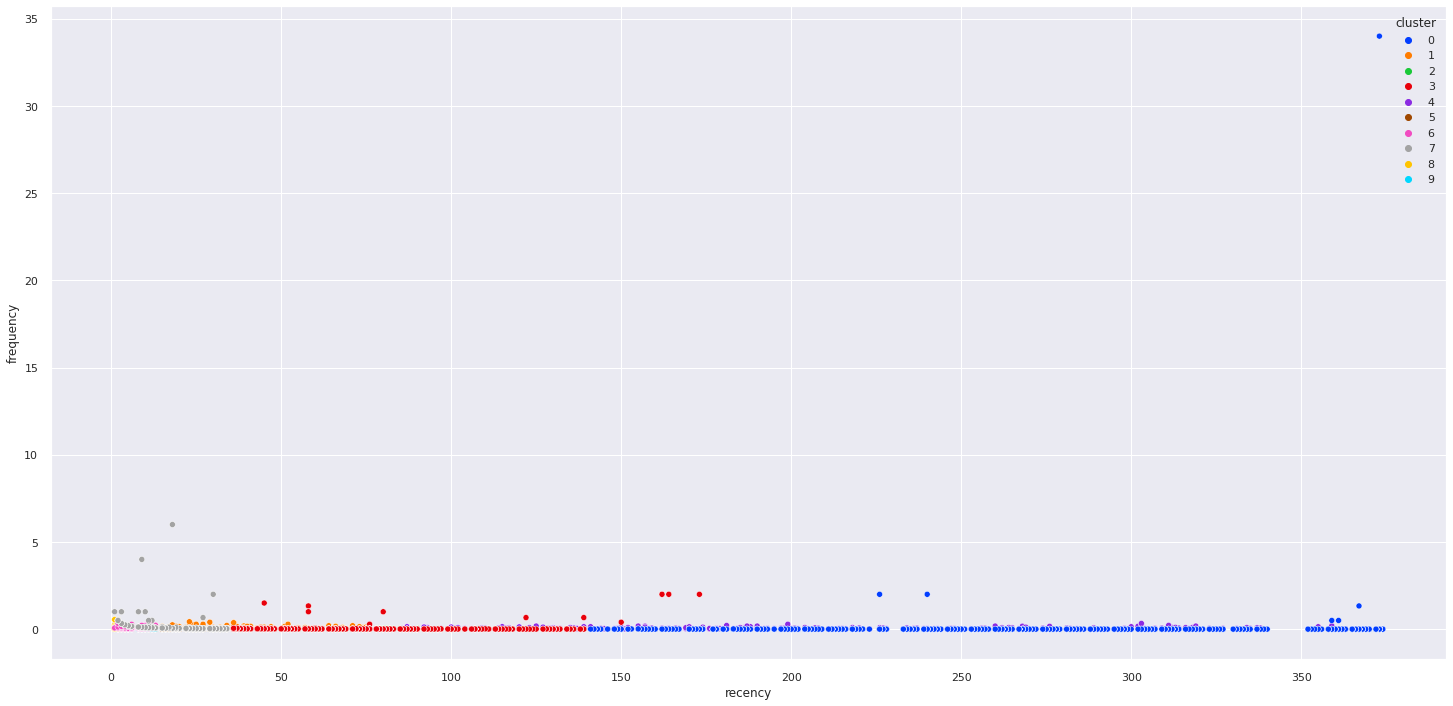

In [84]:
# Ploting recency and frequency for the clusters generated
sns.scatterplot( data = df_res, x = 'recency', y = 'frequency', hue = 'cluster', palette = 'bright');

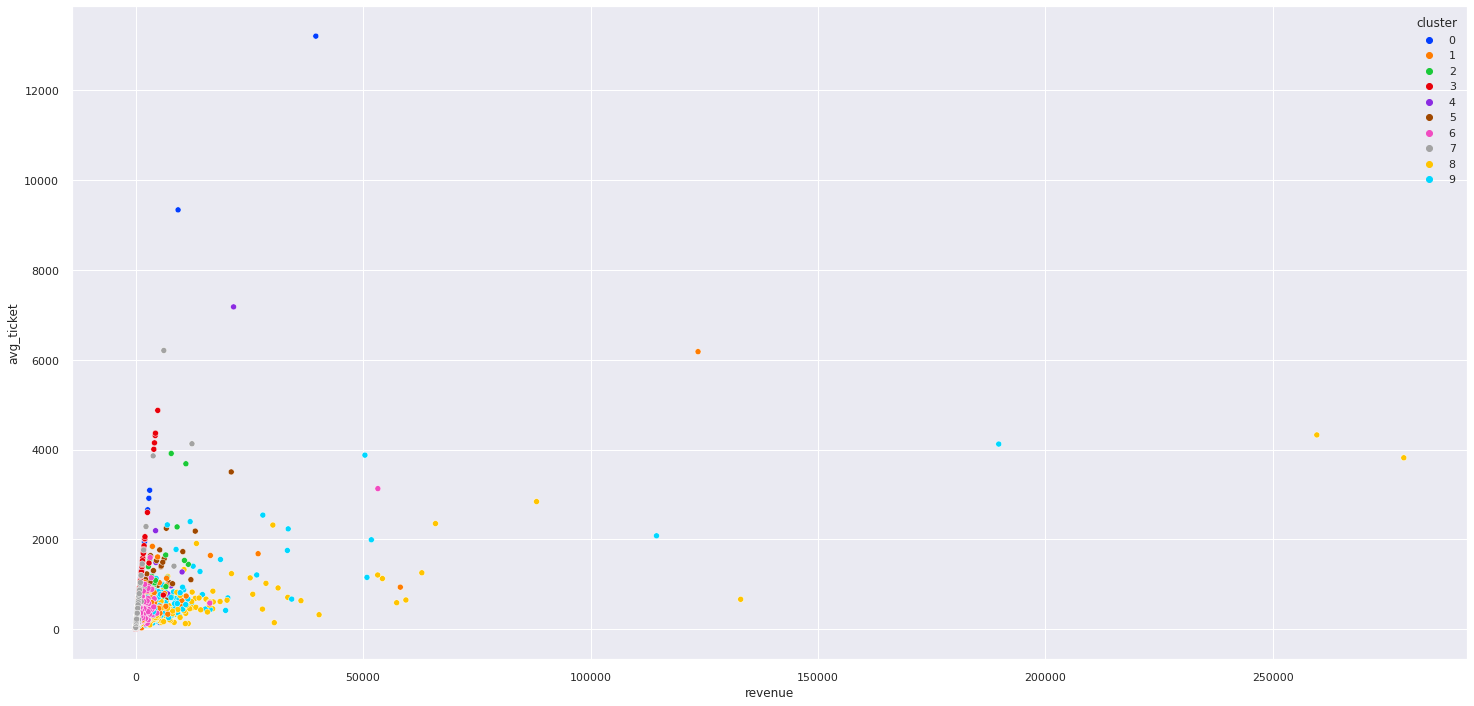

In [86]:
# Ploting recency and frequency for the clusters generated
sns.scatterplot( data = df_res, x = 'revenue', y = 'avg_ticket', hue = 'cluster', palette = 'bright');

# 10 Model Deployment